# 10_Deep_Learning_with_Keras
Feed-forward Multiclass MLP
## Ray Hossain

## Setup

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt

## Pre-Processing Outside

In [2]:
df = pd.read_csv('Processed_Data/81_TopicLDA_Wide.csv')

In [3]:
# Transform the `left_right` column to be 0, 1, 2 instead of -1, 0, 1
df['left_right'] = df['left_right'].map({0:0, 1:1, -1: 2})

In [4]:
df.left_right.value_counts()

left_right
2    591
1    513
0    240
Name: count, dtype: int64

In [5]:
df.fillna({'duration': 0}, inplace=True)

## Model

In [6]:
def build_political_classification_model(df, test_size=0.2, random_state=42):
    """
    Build and train a neural network for political affiliation classification
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the features and target variable
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    model : trained Keras model
    history : training history
    X_test : test features
    y_test : test labels
    """
    # Separate features into categories
    binary_one_hot_columns = ['ml_gender_female', 'ml_married', 'ml_employ', 'ml_degreestatus']
    
    # These are now categorical variables
    categorical_columns = ['polinterest', 'adjustedincome']  # Add any others you identify
    
    continuous_columns = [
        'duration', 'news_proportion', 'age',
        'tf_idf_entity_weighted', 'Current Events', 'Economy', 
        'Elections', 'Entertainment', 'General', 'Law and Order', 
        'Politics', 'Sports', 'Unassigned'
    ]
    
    target_column = 'left_right'
    
    # Preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, continuous_columns),
            ('cat', categorical_transformer, categorical_columns),
            ('binary', 'passthrough', binary_one_hot_columns)  # These are already one-hot encoded
        ])
    
    # Split data
    X = df[continuous_columns + categorical_columns + binary_one_hot_columns]
    y = df[target_column].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Preprocess the data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    # Count number of unique classes
    num_classes = len(np.unique(y))
    
    output_activation = 'softmax'
    output_units = num_classes
    loss_function = 'sparse_categorical_crossentropy'
    
    # Build the model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Proper input layer
        Dense(64, activation='relu'), 
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(output_units, activation=output_activation)
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=loss_function,
        metrics=['accuracy']
    )
    
    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history, X_test, y_test, preprocessor

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on test data
    
    Parameters:
    -----------
    model : trained Keras model
    X_test : test features
    y_test : test labels
    """
    # Make predictions
    if model.output_shape[-1] == 1:  # Binary classification
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    else:  # Multi-class classification
        y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate F1 scores
    if len(np.unique(y_test)) == 2:  # Binary classification
        f1 = f1_score(y_test, y_pred)
        print(f"\nF1 Score: {f1:.4f}")
        
    else:  # Multi-class classification
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        print(f"\nF1 Score (Macro): {f1_macro:.4f}")
        print(f"\nF1 Score (Weighted): {f1_weighted:.4f}")

    
    return accuracy, y_pred

def plot_training_history(history):
    """
    Plot the training history
    
    Parameters:
    -----------
    history : training history object from model.fit()
    """
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


## Evaluation

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3293 - loss: 1.4247 - val_accuracy: 0.3814 - val_loss: 1.0918
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3612 - loss: 1.2634 - val_accuracy: 0.4140 - val_loss: 1.0727
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4227 - loss: 1.1414 - val_accuracy: 0.4372 - val_loss: 1.0701
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4365 - loss: 1.1218 - val_accuracy: 0.4419 - val_loss: 1.0685
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4618 - loss: 1.1069 - val_accuracy: 0.4372 - val_loss: 1.0736
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4852 - loss: 1.0439 - val_accuracy: 0.4372 - val_loss: 1.0751
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5102 - loss: 0.9913 - val_accuracy: 0.4186 - val_loss: 1.0706
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4819 - loss: 1.0187 - val_accuracy: 0.4140 - v

c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

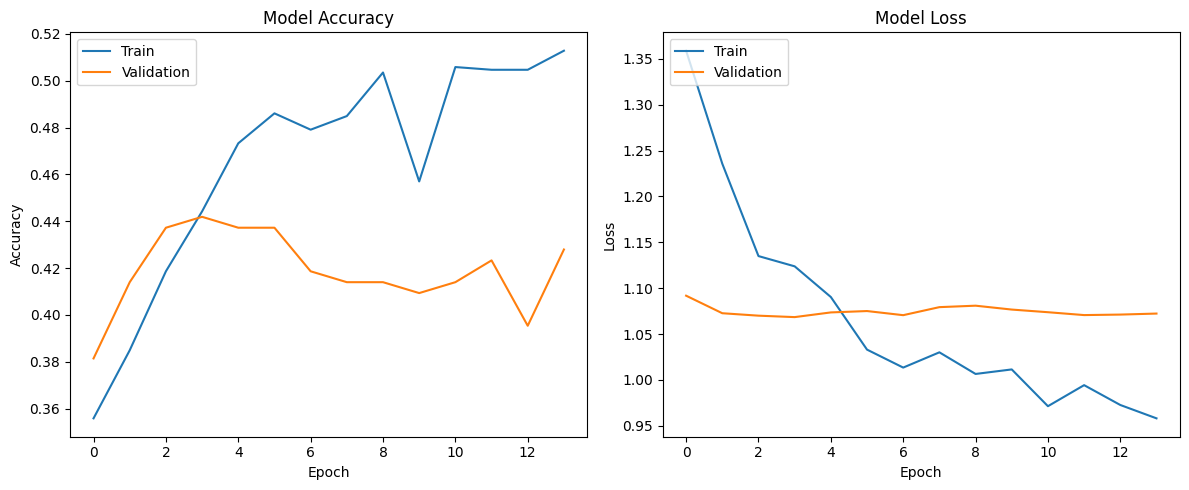

In [7]:
# Build and train the model
model, history, X_test, y_test, scaler = build_political_classification_model(df)

# Evaluate the model
accuracy, y_pred = evaluate_model(model, X_test, y_test)

# Plot training history
plot_training_history(history)


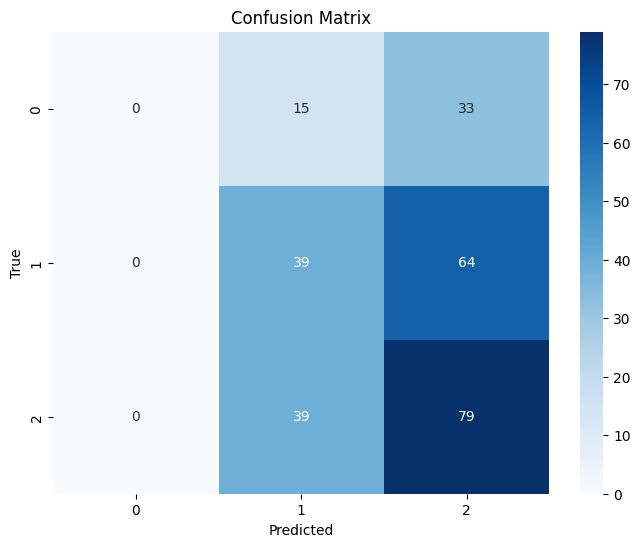

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix explicitly
cm = confusion_matrix(y_test, y_pred)

# Create a more visually appealing confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.43866171003717475


Note: Just incase my brain decides to be small again. The numbers in the confusion matrix represent how well the model performed on the test set N=269